# Project 3 

This notebook is based on `getting_started.ipynb`.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

# optimization
from scipy import optimize

import statsmodels.formula.api as smf

# Read in data

The dataset is `cars.csv`, which contains cleaned and processed data. 

In [3]:
cars = pd.read_csv('cars.csv')
lbl_vars = pd.read_csv('labels_variables.csv')
lbl_vals = pd.read_csv('labels_values.csv')

# convert from dataframe to dict
lbl_vals = {c: lbl_vals[c].dropna().to_dict() for c in lbl_vals.columns}

In [4]:
lbl_vars.set_index('variable', inplace=True)

## Overview of the dataset

In [5]:
lbl_vars.join(cars.mean(numeric_only=True).apply(lambda x: f'{x: .2f}').to_frame('Mean'))

,label,Mean
variable,,
ye,year (=first dimension of panel),84.50
ma,market (=second dimension of panel),3.00
co,model code (=third dimension of panel),207.50
zcode,alternative model code (predecessors and succe...,177.76
brd,brand code,16.79
type,name of brand and model,NaN
brand,name of brand,NaN
model,name of model,NaN
org,"origin code (demand side, country with which c...",2.72


# Set up for analysis

In [6]:
price_var = 'princ'

In [7]:
#cars['logp'] = np.log(cars[price_var])
cars['p'] = cars[price_var]

In [8]:
# new variable: price elasticity heterogeneous for home-region 
cars['p_times_home'] = cars['p'] * cars['home'] #cars[price_var] * cars['home']

### Dummy variables

For working with matrices, we want to have a column for each dummy variable. 

In [9]:
categorical_var = 'cla' #'brand' # name of categorical variable
dummies = pd.get_dummies(cars[categorical_var]) # creates a matrix of dummies for each value of dummyvar
x_vars_dummies = list(dummies.columns[1:].values) # omit a reference category, here it is the first (hence columns[1:])

# add dummies to the dataframe 
assert dummies.columns[0] not in cars.columns, f'It looks like you have already added this dummy to the dataframe. Avoid duplicates! '
cars = pd.concat([cars,dummies], axis=1)

### `x_vars`: List of regressors to be used 

In [10]:
x_vars = ['p', 'p_times_home', 'home', 'cy', 'hp', 'we', 'li'] + x_vars_dummies # choose preferred variables here 
print(f'K = {len(x_vars)} variables selected.')

K = 11 variables selected.


In [11]:
K = len(x_vars)
N = cars.ma.nunique() * cars.ye.nunique()
J = 40 
x = cars[x_vars].values.reshape((N,J,K))
#y = np.log(cars['s'].values.reshape((N,J)))
y = cars['s'].values.reshape((N,J))

# standardize x
# x = ((x - x.mean(0).mean(0))/(x.std(0).std(0)))

# Analysis Begins

In [12]:
import estimation as est
from scipy.stats import norm
from numpy.random import default_rng

In [13]:

def utility(theta, x): 
    '''utility: compute the deterministic part of utility, v, and max-rescale it
    Args. 
        theta: (K,) vector of parameters 
        x: (N,J,K) matrix of covariates 
    
    Returns
        v: (N,J) matrix of (deterministic) utility components
    '''
    assert theta.ndim == 1 

    # deterministic utility 
    v = x @ theta # (N,J) 
    v = v-v.max(axis=1, keepdims=True)  # broadcast: (N,J)-(N,1)=(N,J)
    
    return v 

In [14]:

def loglikelihood(theta, y, x): 
    '''loglikelihood()
    Args. 
        theta: (K,) vector of parameters 
        x: (N,J,K) matrix of covariates 
        y: (N,J) matrix of realized market shares
    
    Returns
        ll_i: (N,) vector of loglikelihood contributions for market i
    '''
    assert theta.ndim == 1 

    # deterministic utility 
    v = utility(theta, x)

    # denominator 
    denom = np.exp(v).sum(axis=1,keepdims=True) # (N,1)

    # utility at chosen alternative 
    v_i = v

    # likelihood 
    ll_i = v_i - np.log(denom) # difference between two 1-dimensional arrays (N,J)
    ll_i = (y @ ll_i.T).diagonal()

    return ll_i

In [15]:
def q(theta, y, x): 
    '''q: Criterion function, passed to estimation.estimate().
    '''
    return -loglikelihood(theta, y, x)

In [16]:
def choice_prob(theta, x):
    '''choice_prob(): Computes the (N,J) matrix of choice probabilities 
    Args. 
        theta: (K,) vector of parameters 
        x: (N,J,K) matrix of covariates 
    
    Returns
        ccp: (N,J) matrix of probabilities 
    '''
    assert theta.ndim == 1, f'theta should have ndim == 1, got {theta.ndim}'
    
    # deterministic utility 
    v = utility(theta, x)
    
    # denominator 
    denom = np.exp(v).sum(axis=1, keepdims=True) # (N,1)
    
    # Conditional choice probabilites
    ccp = np.exp(v) / denom
    
    return ccp

## MLE of CLogit

In [17]:
# Make sure all element in x,y can perform claculation
y = y.astype('float')
x = x.astype('float') 

theta0 = np.zeros((K,)) # initial value

In [18]:
res = est.estimate(q, theta0, y, x,cov_type='Sandwich')
print('\n estimates of beta:')
print(res['theta'])

Optimization terminated successfully.
         Current function value: 3.493146
         Iterations: 48
         Function evaluations: 660
         Gradient evaluations: 55

 estimates of beta:
[-8.54245619e-01 -2.98782388e-01  1.52376366e+00  4.25589545e-04
 -2.14054722e-02  7.37737288e-04 -2.95877430e-02  1.98122903e-01
  1.84932804e-01  1.10770280e-01  7.70710082e-01]


In [19]:
def calc_norm(q, theta):
    g = est.centered_grad(q, theta) # (N,K)
    g = np.mean(g, axis=0) # (K,)
    return np.mean(g ** 2) # 2-norm: 

q1 = lambda theta: 1/N*np.sum(q(theta, y, x))
print(f'q(thetahat)        = {q1(res["theta"]): 8.4g}')
print(f'2-norm of gradient = {calc_norm(q1, res["theta"]): 8.4g}')

q(thetahat)        =    3.493
2-norm of gradient =  9.273e-08


## Measuring Home-bias Effect

In [20]:
thetahat = res['theta']

PE_own=np.zeros((N,J))    # partial effect on itself in each market
PE_all=np.zeros((J,N,J))  # element (j1,i,j2) = j1 home dummy's impact on j2's share in market i
APE_own=np.zeros((J,))    # APE (average across market) on itself
APE_all=np.zeros((J,J))   # element (j1,j2) = j1 home dummy's average impact on j2's share 
APE_percentage=np.zeros((J,)) # element j = j's APE_own/average market share with home dummy=0

# indicies that contian home dummy
home_loc_1=1  # price_times_home dummy
home_loc_2=2  # home dummy

# Since market share in each market is calculated independently in matrix form
# we can avoid the outer loop a.e., i in range(N)
for j in range(J): # change car j's home dummy from 0 to 1
    # set home dummy to be 0
    x_home_0 = x.copy()
    x_home_0[:,j,home_loc_1]=0
    x_home_0[:,j,home_loc_2]=0
    # set home dummy to be 1
    x_home_1 = x.copy()
    x_home_1[:,j,home_loc_1]=x_home_1[:,j,0]
    x_home_1[:,j,home_loc_2]=1
    
    PE=choice_prob(thetahat,x_home_1)-choice_prob(thetahat,x_home_0)
    PE_all[j,:,:]=PE
    PE_own[:,j]=PE[:,j]
    APE_all[j,:]=np.mean(PE,axis=0)
    APE_own[j]=np.mean(PE,axis=0)[j]
    APE_percentage[j]=APE_own[j]/np.mean(choice_prob(thetahat,x_home_0),axis=0)[j]

**Car j's partial effect on car j's market share (for each car j) in market 1:**

In [21]:
print('PE on itself for each car in market 1:')
print(PE_own[0,:]) # <-- display other market i by changing 0 to i-1 

PE on itself for each car in market 1:
[0.03653782 0.07770701 0.07380393 0.05542167 0.0876072  0.03924489
 0.07452168 0.07732832 0.03939554 0.05110284 0.08902452 0.06607767
 0.07151022 0.05737592 0.0683678  0.05181957 0.08541523 0.06526632
 0.0382538  0.0343565  0.02551804 0.06665667 0.04045708 0.07772848
 0.05918589 0.05175016 0.03776054 0.07603719 0.07766824 0.03959719
 0.04579478 0.06894188 0.05576145 0.05192862 0.07201447 0.07124155
 0.07944414 0.08356778 0.03508769 0.05990332]


**Home bias effect of each car:**

In [22]:
print('home bias effect of each car (APE):')
print(APE_own)

home bias effect of each car (APE):
[0.02885574 0.02544759 0.03140545 0.03693861 0.04074586 0.04147846
 0.04107323 0.04224206 0.04275442 0.04025134 0.03911202 0.03907105
 0.03820475 0.0371564  0.03738915 0.03988144 0.03892331 0.03723763
 0.04143306 0.03969966 0.03745992 0.03893232 0.03738306 0.03852973
 0.03746698 0.03886488 0.04080831 0.04165673 0.0405212  0.0389481
 0.03955167 0.03951931 0.03804718 0.03988696 0.03955405 0.04118041
 0.04125463 0.04234566 0.03809393 0.03653956]


**Average level of home bias effect across all cars:**

In [23]:
print('average APE across all cars:',np.mean(APE_own))

average APE across all cars: 0.03864614555024086


**Home bias measured in percentage increase:**

$$\frac{share|_{home=1}-share|_{home=0}}{share|_{home=0}}\approx2.5$$

In [24]:
print('Home bias measured in percentage:')
print(APE_percentage)

Home bias measured in percentage:
[2.4246567  2.36818394 2.48367813 2.51212043 2.63379521 2.60083774
 2.62731846 2.62324659 2.62239751 2.57944731 2.5673227  2.57465568
 2.54676849 2.52385622 2.531884   2.57382447 2.52964356 2.50397963
 2.56402251 2.56377115 2.56843595 2.5720563  2.554271   2.56211402
 2.56035346 2.56500227 2.60140126 2.60848891 2.58992883 2.58470043
 2.59356214 2.60435025 2.58729035 2.61255795 2.62032745 2.63129332
 2.57873037 2.57057359 2.52822299 2.48063611]


## Demand Elasticity

In [25]:
def demand_elasticity(x,ccp1,thetahat,price=0,price_times_home=1,rel_change_x=1e-3):

    N,J,K=x.shape
    E_own   = np.zeros((N, J))
    E_cross = np.zeros((N, J))

    for j in range(J):
        # A. copy 
        x2 = x.copy()
    
        # B. increase price just for car j 
        x2[:, j, price] = (1+rel_change_x)*x2[:,j,price]
        x2[:, j, price_times_home] = (1+rel_change_x)*x2[:,j,price_times_home] 

        # C. evaluate CCPs
        ccp2 = choice_prob(thetahat,x2) 
    
        # D. percentage change in CCPs 
        rel_change_y = (ccp2-ccp1)/ccp1 
    
        # E. elasticities 
        elasticity = rel_change_y/rel_change_x
    
        E_own[:, j] = elasticity[:,j] 
    
        k_not_j = [k for k in range(J) if k != j] # indices for all other cars than j 
        E_cross[:, j] = np.mean(elasticity[:,k_not_j],axis=1) # Avg. among the cars k_not_j

    return E_own,E_cross

In [26]:
# a faster way to calculate own-price elasticity 
def own_price_elasticity(x,thetahat,home_loc_1=1,home_loc_2=2,price=0,price_times_home=1,
                              rel_change_x=1e-5,solution_method='numerical'):

    N,J,K=x.shape
    # own-price elasticity
    PE_price_home_0=np.zeros((N,J))
    PE_price_home_1=np.zeros((N,J))
    Elasticity_price_home_0=np.zeros((N,J))
    Elasticity_price_home_1=np.zeros((N,J))

    # change car j's home dummy from 0 to 1
    for j in range(J): 

        # set home dummy to be 0
        x_home_0 = x.copy()
        x_home_0[:,j,home_loc_1]=0
        x_home_0[:,j,home_loc_2]=0
        # set home dummy to be 1
        x_home_1 = x.copy()
        x_home_1[:,j,home_loc_1]=x_home_1[:,j,0]
        x_home_1[:,j,home_loc_2]=1
        
        # choice probability
        ccp_home_0  = choice_prob(thetahat,x_home_0) 
        ccp_home_1  = choice_prob(thetahat,x_home_1)

        if solution_method=='numerical':

            # slight increase in price   
            x2_home_0 = x_home_0.copy()
            x2_home_0[:, j, price]            = (1+rel_change_x)*x2_home_0[:,j,price]
            x2_home_0[:, j, price_times_home] = (1+rel_change_x)*x2_home_0[:,j,price_times_home] 
            x2_home_1 = x_home_1.copy()
            x2_home_1[:, j, price]            = (1+rel_change_x)*x2_home_1[:,j,price]
            x2_home_1[:, j, price_times_home] = (1+rel_change_x)*x2_home_1[:,j,price_times_home] 

            ccp2_home_0 = choice_prob(thetahat,x2_home_0) 
            ccp2_home_1 = choice_prob(thetahat,x2_home_1)

            rel_change_y_home_0 = (ccp2_home_0-ccp_home_0)/ccp_home_0
            rel_change_y_home_1 = (ccp2_home_1-ccp_home_1)/ccp_home_1
            elasticity_home_0   = rel_change_y_home_0/rel_change_x
            elasticity_home_1   = rel_change_y_home_1/rel_change_x
 
            Elasticity_price_home_0[:,j]=elasticity_home_0[:,j]
            Elasticity_price_home_1[:,j]=elasticity_home_1[:,j]
        else:
            # equivalent analytical approach 
            PE_price_home_0[:,j]=(thetahat[price]*ccp_home_0*(1-ccp_home_0))[:,j]
            PE_price_home_1[:,j]=((thetahat[price]+thetahat[price_times_home])*ccp_home_1*(1-ccp_home_1))[:,j]
            Elasticity_price_home_0[:,j]=PE_price_home_0[:,j]*(x_home_0[:,:,price]/ccp_home_0)[:,j]
            Elasticity_price_home_1[:,j]=PE_price_home_1[:,j]*(x_home_1[:,:,price]/ccp_home_1)[:,j]

    return Elasticity_price_home_0,Elasticity_price_home_1

In [27]:
thetahat = res['theta']

# Original choice probabilites
ccp1 = choice_prob(thetahat, x)

### Demand Elasticity w.r.t. Price

Let's first see the original demand elasticity. (No changes of home dummy here.)

In [28]:
E1,E2=demand_elasticity(x,ccp1,thetahat,rel_change_x=1e-5)

print(f'Own-price elasticity:  {np.mean(E1).round(4)}')
print(f'Cross-price elasticity: {np.mean(E2).round(4)}')

Own-price elasticity:  -0.7032
Cross-price elasticity: 0.0178


### Home-bias Impact on Own-price Elasticity

In [29]:
Elasticity_all_market_home_0,Elasticity_all_market_home_1=own_price_elasticity(x,thetahat)
Elasticity_home_0=np.mean(Elasticity_all_market_home_0,axis=0)
Elasticity_home_1=np.mean(Elasticity_all_market_home_1,axis=0)

**Own-price elasticity (non-domestic):**

Car $j$'s own-price elasticity by setting $j$'s home dummy to 0, given other car's home dummy unchanged.

In [30]:
print('Each cars own price elasticity by setting its home dummy to 0:')
print(Elasticity_home_0)

Each cars own price elasticity by setting its home dummy to 0:
[-0.78325645 -0.87723682 -0.75589413 -0.7071575  -0.58064317 -0.59668099
 -0.57388158 -0.57377772 -0.55332111 -0.59464016 -0.62765344 -0.62699419
 -0.65101769 -0.67141822 -0.66992105 -0.61148538 -0.65039533 -0.68791335
 -0.63316943 -0.63314892 -0.66557343 -0.64853723 -0.64962578 -0.6350767
 -0.65500405 -0.62211397 -0.5886613  -0.581117   -0.60455354 -0.61940409
 -0.60134858 -0.61867454 -0.63347149 -0.58314743 -0.57704076 -0.56243003
 -0.59182242 -0.59492032 -0.65030535 -0.72472211]


**Own-price elasticity (domestic):**

Car $j$'s own-price elasticity by setting $j$'s home dummy to 1, given other car's home dummy unchanged.

In [31]:
print('Own price elasticity by setting home dummy to 1 for each car:')
print(Elasticity_home_1)

Own price elasticity by setting home dummy to 1 for each car:
[-1.02926314 -1.15779344 -0.99296263 -0.92434611 -0.7560163  -0.77555163
 -0.7459674  -0.74513589 -0.71683828 -0.77249393 -0.81718048 -0.81662172
 -0.84856029 -0.87593955 -0.87404971 -0.79518584 -0.84649543 -0.89735759
 -0.82339106 -0.82404389 -0.86976853 -0.84609818 -0.84755716 -0.82737028
 -0.8549355  -0.80959021 -0.76474149 -0.75450831 -0.78613642 -0.80680207
 -0.78232261 -0.80660206 -0.82657889 -0.75830146 -0.75057391 -0.73049193
 -0.76789454 -0.77097913 -0.84608122 -0.94647492]


**Home bias impact on demand elasticity w.r.t. price:**

$$\Delta|\epsilon|=|\epsilon_{home=1}|-|\epsilon_{home=0}|$$

In [32]:
print('home bias increase the price sensitiveness:')
print(np.abs(Elasticity_home_1-Elasticity_home_0))

home bias increase the price sensitiveness:
[0.24600669 0.28055663 0.2370685  0.2171886  0.17537313 0.17887064
 0.17208582 0.17135817 0.16351717 0.17785376 0.18952705 0.18962752
 0.1975426  0.20452134 0.20412866 0.18370047 0.1961001  0.20944424
 0.19022162 0.19089497 0.2041951  0.19756095 0.19793138 0.19229358
 0.19993145 0.18747624 0.17608019 0.17339132 0.18158288 0.18739798
 0.18097403 0.18792752 0.1931074  0.17515403 0.17353315 0.1680619
 0.17607212 0.1760588  0.19577586 0.22175281]


## Delta Method

In [33]:
def get_se(grad, cov):
    cov_me = grad@cov@grad.T
    return np.sqrt(np.diag(cov_me))

In [34]:
thetahat = res['theta']
covhat   = res['cov']

# V_{i,j,j} of partial effect on itself for each market
V_own_PE=np.zeros((N,J))

# indicies that contian home dummy
home_loc_1=1  # price_times_home dummy
home_loc_2=2  # home dummy

# Since market share in each market is calculated independently in matrix form
# we can avoid the outer loop a.e., i in range(N)
for j in range(J): # change car j's home dummy from 0 to 1
    # set home dummy to be 0
    x_home_0 = x.copy()
    x_home_0[:,j,home_loc_1]=0
    x_home_0[:,j,home_loc_2]=0
    # set home dummy to be 1
    x_home_1 = x.copy()
    x_home_1[:,j,home_loc_1]=x_home_1[:,j,0]
    x_home_1[:,j,home_loc_2]=1
    
    # for each j, gradient for all markets in matrix form
    gradient_part_1=choice_prob(thetahat,x_home_1)[:,j].reshape(-1,1)*x_home_1[:,j,:]
    gradient_part_0=choice_prob(thetahat,x_home_0)[:,j].reshape(-1,1)*x_home_0[:,j,:]
    gradient=gradient_part_1-gradient_part_0

    V_own_PE[:,j] = get_se(gradient, covhat)

**Confidence interval of PE:**

In [35]:
PE_lower_bound=PE_own-norm.ppf(q=0.975)*np.sqrt(V_own_PE/N)
PE_upper_bound=PE_own+norm.ppf(q=0.975)*np.sqrt(V_own_PE/N)

**Display part of the results:**

In [36]:
market=0          # <-- change here to see different market
choice=range(5)   # <-- change here to see different cars

car_display=[]
for j in range(J):
    car_display.append(f'car {j+1}')

PE_dict = {'choice':         np.vstack([car_display[j] for j in choice])[:,0],
           'PE':             np.vstack([PE_own[market,j] for j in choice])[:,0],
           'CI lower bound': np.vstack([PE_lower_bound[market,j] for j in choice])[:,0],
           'CI upper bound': np.vstack([PE_upper_bound[market,j] for j in choice])[:,0],
           }
tab = pd.DataFrame(PE_dict,index=[f'market {market+1}' for j in choice])
tab.index.name = f'market'
tab.round(4)

,choice,PE,CI lower bound,CI upper bound
market,,,,
market 1,car 1,0.0365,0.0270,0.0461
market 1,car 2,0.0777,0.0641,0.0914
market 1,car 3,0.0738,0.0604,0.0872
market 1,car 4,0.0554,0.0429,0.0679
market 1,car 5,0.0876,0.0721,0.1031


**Latex code (needing manual modification):**

In [37]:
tab.to_latex()

'\\begin{tabular}{llrrr}\n\\toprule\n & choice & PE & CI lower bound & CI upper bound \\\\\nmarket &  &  &  &  \\\\\n\\midrule\nmarket 1 & car 1 & 0.036538 & 0.027020 & 0.046055 \\\\\nmarket 1 & car 2 & 0.077707 & 0.064064 & 0.091350 \\\\\nmarket 1 & car 3 & 0.073804 & 0.060396 & 0.087212 \\\\\nmarket 1 & car 4 & 0.055422 & 0.042921 & 0.067922 \\\\\nmarket 1 & car 5 & 0.087607 & 0.072088 & 0.103127 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Bootstrapping

Attention: the standard deviation we derived here cannot be used in hypothesis testing. It is only a measure of APE's variation.

In [38]:
def bootstrap_sample(y,x): 
    '''bootstrap_sample: samples a new dataset (with replacement) from the input. 
    Args. 
        y: (N,J) matrix
        x: (N,J,K) matrix 
    Returns
        tuple: y_i, x_i 
            y_i: (N,J) matrix
            x_i: (N,J,K) matrix 
    '''
    N,J = y.shape
    
    # FILL IN 
    ii_boot = np.random.choice(N,size=N,replace=True) # vector of indices for rows 

    y_i = y[ii_boot] # selection of N rows from y 
    x_i = x[ii_boot] # selection of N rows from x 
    
    return y_i, x_i 

In [39]:
def estimate_and_compute_APE(y, x, theta_start,q,home_loc_1=1,home_loc_2=2): 
    
    N,J,K = x.shape
    
    # 1. estimate 
    res_new = est.estimate(q, theta_start, y, x,cov_type='Sandwich') # estimate parameters
    thetahat_new = res_new['theta']

    APE_own_new=np.zeros((J,))    # APE (average across market) on itself
    APE_all_new=np.zeros((J,J))   # element (j1,j2) = j1 home dummy's average impact on j2's share 
    APE_percent_new=np.zeros((J,)) # element j = j's APE_own/average market share with home dummy=0

    for j in range(J): # change car j's home dummy from 0 to 1

        # set home dummy to be 0
        x_home_0_new = x.copy()
        x_home_0_new[:,j,home_loc_1]=0
        x_home_0_new[:,j,home_loc_2]=0
        # set home dummy to be 1
        x_home_1_new = x.copy()
        x_home_1_new[:,j,home_loc_1]=x_home_1_new[:,j,0]
        x_home_1_new[:,j,home_loc_2]=1
    
        PE=choice_prob(thetahat_new,x_home_1_new)-choice_prob(thetahat_new,x_home_0_new)
        APE_all_new[j,:]=np.mean(PE,axis=0)
        APE_own_new[j]=np.mean(PE,axis=0)[j]
        APE_percent_new[j]=APE_own_new[j]/np.mean(choice_prob(thetahat_new,x_home_0_new),axis=0)[j]
    
    # 4. return 
    return APE_all_new,APE_own_new,APE_percent_new

**Check the function yields the correct results:**

In [40]:
E1,E2,E3=estimate_and_compute_APE(y, x, theta0,q)
print(E2==APE_own)

Optimization terminated successfully.
         Current function value: 3.493146
         Iterations: 48
         Function evaluations: 660
         Gradient evaluations: 55
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


**Run the bootstrapping:**

In [41]:
nboot = 1000  # Number of bootstraps, should ideally be very large 

# Set seed for random sampling.
seed = 42
rng = default_rng()

# initialize 
APE_all_boot     = np.empty((nboot,J,J))
APE_own_boot     = np.empty((nboot,J))
APE_percent_boot = np.empty((nboot,J))

for i in range(nboot): 
    print(f'Bootstrap iteration {i+1}/{nboot}')
    
    # 1. choose which individuals to draw
    y_i, x_i = bootstrap_sample(y,x) # call the bootstrap sample function 
    # 2. estimate and compute 
    E1,E2,E3 = estimate_and_compute_APE(y_i,x_i,thetahat,q) # estimate and compute APE using the function from earlier 
    APE_all_boot[i,:] = E1
    APE_own_boot[i,:] = E2
    APE_percent_boot[i,:] = E3

Bootstrap iteration 1/1000
Optimization terminated successfully.
         Current function value: 3.496452
         Iterations: 36
         Function evaluations: 468
         Gradient evaluations: 39
Bootstrap iteration 2/1000
Optimization terminated successfully.
         Current function value: 3.491696
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 3/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.480276
         Iterations: 38
         Function evaluations: 960
         Gradient evaluations: 79
Bootstrap iteration 4/1000
Optimization terminated successfully.
         Current function value: 3.516024
         Iterations: 43
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 5/1000
Optimization terminated successfully.
         Current function value: 3.496007
         Iterations: 46
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 6/1000
Optimization terminated successfully.
         Current function value: 3.501418
         Iterations: 43
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 7/1000
Optimization terminated successfully.
         Current function value: 3.481176
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 8/1000
Optimization terminated successfully.


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.491402
         Iterations: 45
         Function evaluations: 636
         Gradient evaluations: 53
Bootstrap iteration 19/1000
Optimization terminated successfully.
         Current function value: 3.498338
         Iterations: 36
         Function evaluations: 468
         Gradient evaluations: 39
Bootstrap iteration 20/1000
Optimization terminated successfully.
         Current function value: 3.474211
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 21/1000
Optimization terminated successfully.
         Current function value: 3.489165
         Iterations: 43
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 22/1000
Optimization terminated successfully.
         Current function value: 3.494322
         Iterations: 36
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 23/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.488313
         Iterations: 45
         Function evaluations: 648
         Gradient evaluations: 54
Bootstrap iteration 24/1000
Optimization terminated successfully.
         Current function value: 3.510044
         Iterations: 44
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 25/1000
Optimization terminated successfully.
         Current function value: 3.487040
         Iterations: 45
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 26/1000
Optimization terminated successfully.
         Current function value: 3.487900
         Iterations: 45
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 27/1000
Optimization terminated successfully.
         Current function value: 3.477312
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 28/1000
Optimization terminated successfu

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.496530
         Iterations: 42
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 43/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.483283
         Iterations: 45
         Function evaluations: 624
         Gradient evaluations: 52
Bootstrap iteration 44/1000
Optimization terminated successfully.
         Current function value: 3.505224
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 45/1000
Optimization terminated successfully.
         Current function value: 3.495736
         Iterations: 43
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 46/1000
Optimization terminated successfully.
         Current function value: 3.486711
         Iterations: 34
         Function evaluations: 468
         Gradient evaluations: 39
Bootstrap iteration 47/1000
Optimization terminated successfully.
         Current function value: 3.503534
         Iterations: 46
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 48/1000
Optimization terminated successfu

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.483280
         Iterations: 44
         Function evaluations: 1044
         Gradient evaluations: 86
Bootstrap iteration 54/1000
Optimization terminated successfully.
         Current function value: 3.492139
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 55/1000
Optimization terminated successfully.
         Current function value: 3.495743
         Iterations: 37
         Function evaluations: 480
         Gradient evaluations: 40
Bootstrap iteration 56/1000
Optimization terminated successfully.
         Current function value: 3.499450
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 57/1000
Optimization terminated successfully.
         Current function value: 3.495117
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 58/1000
Optimization terminated successf

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.484456
         Iterations: 45
         Function evaluations: 636
         Gradient evaluations: 53
Bootstrap iteration 99/1000
Optimization terminated successfully.
         Current function value: 3.498411
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 100/1000
Optimization terminated successfully.
         Current function value: 3.479706
         Iterations: 42
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 101/1000
Optimization terminated successfully.
         Current function value: 3.490797
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 102/1000
Optimization terminated successfully.
         Current function value: 3.490380
         Iterations: 37
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 103/1000
Optimization terminated succe

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.504916
         Iterations: 46
         Function evaluations: 1353
         Gradient evaluations: 111
Bootstrap iteration 107/1000
Optimization terminated successfully.
         Current function value: 3.483091
         Iterations: 42
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 108/1000
Optimization terminated successfully.
         Current function value: 3.488997
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 109/1000
Optimization terminated successfully.
         Current function value: 3.500612
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 110/1000
Optimization terminated successfully.
         Current function value: 3.495220
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 111/1000
Optimization terminated su

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.493588
         Iterations: 36
         Function evaluations: 804
         Gradient evaluations: 66
Bootstrap iteration 157/1000
Optimization terminated successfully.
         Current function value: 3.494626
         Iterations: 43
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 158/1000
Optimization terminated successfully.
         Current function value: 3.506414
         Iterations: 35
         Function evaluations: 504
         Gradient evaluations: 42
Bootstrap iteration 159/1000
Optimization terminated successfully.
         Current function value: 3.485482
         Iterations: 42
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 160/1000
Optimization terminated successfully.
         Current function value: 3.506069
         Iterations: 43
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 161/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.479947
         Iterations: 49
         Function evaluations: 1344
         Gradient evaluations: 111
Bootstrap iteration 188/1000
Optimization terminated successfully.
         Current function value: 3.499862
         Iterations: 43
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 189/1000
Optimization terminated successfully.
         Current function value: 3.484237
         Iterations: 47
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 190/1000
Optimization terminated successfully.
         Current function value: 3.483218
         Iterations: 49
         Function evaluations: 744
         Gradient evaluations: 62
Bootstrap iteration 191/1000
Optimization terminated successfully.
         Current function value: 3.501752
         Iterations: 42
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 192/1000
Optimization terminated su

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.482283
         Iterations: 45
         Function evaluations: 636
         Gradient evaluations: 53
Bootstrap iteration 206/1000
Optimization terminated successfully.
         Current function value: 3.480785
         Iterations: 45
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 207/1000
Optimization terminated successfully.
         Current function value: 3.497288
         Iterations: 42
         Function evaluations: 540
         Gradient evaluations: 45
Bootstrap iteration 208/1000
Optimization terminated successfully.
         Current function value: 3.496991
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 209/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.493982
         Iterations: 45
         Function evaluations: 624
         Gradient evaluations: 52
Bootstrap iteration 210/1000
Optimization terminated successfully.
         Current function value: 3.488862
         Iterations: 45
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 211/1000
Optimization terminated successfully.
         Current function value: 3.477696
         Iterations: 35
         Function evaluations: 480
         Gradient evaluations: 40
Bootstrap iteration 212/1000
Optimization terminated successfully.
         Current function value: 3.484956
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 213/1000
Optimization terminated successfully.
         Current function value: 3.489287
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 214/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.520018
         Iterations: 48
         Function evaluations: 780
         Gradient evaluations: 65
Bootstrap iteration 227/1000
Optimization terminated successfully.
         Current function value: 3.496493
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 228/1000
Optimization terminated successfully.
         Current function value: 3.481852
         Iterations: 35
         Function evaluations: 504
         Gradient evaluations: 42
Bootstrap iteration 229/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.507904
         Iterations: 44
         Function evaluations: 768
         Gradient evaluations: 64
Bootstrap iteration 230/1000
Optimization terminated successfully.
         Current function value: 3.483616
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 231/1000
Optimization terminated successfully.
         Current function value: 3.501133
         Iterations: 37
         Function evaluations: 504
         Gradient evaluations: 42
Bootstrap iteration 232/1000
Optimization terminated successfully.
         Current function value: 3.487550
         Iterations: 43
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 233/1000
Optimization terminated successfully.
         Current function value: 3.492451
         Iterations: 45
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 234/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.502070
         Iterations: 39
         Function evaluations: 672
         Gradient evaluations: 56
Bootstrap iteration 259/1000
Optimization terminated successfully.
         Current function value: 3.488327
         Iterations: 46
         Function evaluations: 636
         Gradient evaluations: 53
Bootstrap iteration 260/1000
Optimization terminated successfully.
         Current function value: 3.482641
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 261/1000
Optimization terminated successfully.
         Current function value: 3.491892
         Iterations: 38
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 262/1000
Optimization terminated successfully.
         Current function value: 3.472987
         Iterations: 36
         Function evaluations: 528
         Gradient evaluations: 44
Bootstrap iteration 263/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.501913
         Iterations: 49
         Function evaluations: 1092
         Gradient evaluations: 90
Bootstrap iteration 265/1000
Optimization terminated successfully.
         Current function value: 3.481254
         Iterations: 42
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 266/1000
Optimization terminated successfully.
         Current function value: 3.502916
         Iterations: 42
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 267/1000
Optimization terminated successfully.
         Current function value: 3.484410
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 268/1000
Optimization terminated successfully.
         Current function value: 3.480032
         Iterations: 42
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 269/1000
Optimization terminated suc

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.480779
         Iterations: 48
         Function evaluations: 732
         Gradient evaluations: 61
Bootstrap iteration 304/1000
Optimization terminated successfully.
         Current function value: 3.503971
         Iterations: 35
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 305/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.489863
         Iterations: 45
         Function evaluations: 636
         Gradient evaluations: 53
Bootstrap iteration 306/1000
Optimization terminated successfully.
         Current function value: 3.484163
         Iterations: 43
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 307/1000
Optimization terminated successfully.
         Current function value: 3.490949
         Iterations: 35
         Function evaluations: 480
         Gradient evaluations: 40
Bootstrap iteration 308/1000
Optimization terminated successfully.
         Current function value: 3.484338
         Iterations: 36
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 309/1000
Optimization terminated successfully.
         Current function value: 3.479895
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 310/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.486960
         Iterations: 45
         Function evaluations: 624
         Gradient evaluations: 52
Bootstrap iteration 319/1000
Optimization terminated successfully.
         Current function value: 3.493066
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 320/1000
Optimization terminated successfully.
         Current function value: 3.497608
         Iterations: 42
         Function evaluations: 708
         Gradient evaluations: 59
Bootstrap iteration 321/1000
Optimization terminated successfully.
         Current function value: 3.491435
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 322/1000
Optimization terminated successfully.
         Current function value: 3.496683
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 323/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.488483
         Iterations: 47
         Function evaluations: 648
         Gradient evaluations: 54
Bootstrap iteration 330/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.490481
         Iterations: 47
         Function evaluations: 672
         Gradient evaluations: 56
Bootstrap iteration 331/1000
Optimization terminated successfully.
         Current function value: 3.489479
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 332/1000
Optimization terminated successfully.
         Current function value: 3.510313
         Iterations: 35
         Function evaluations: 456
         Gradient evaluations: 38
Bootstrap iteration 333/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.485679
         Iterations: 46
         Function evaluations: 696
         Gradient evaluations: 58
Bootstrap iteration 334/1000
Optimization terminated successfully.
         Current function value: 3.461345
         Iterations: 45
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 335/1000
Optimization terminated successfully.
         Current function value: 3.500332
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 336/1000
Optimization terminated successfully.
         Current function value: 3.488039
         Iterations: 41
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 337/1000
Optimization terminated successfully.
         Current function value: 3.490234
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 338/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.501232
         Iterations: 46
         Function evaluations: 660
         Gradient evaluations: 55
Bootstrap iteration 348/1000
Optimization terminated successfully.
         Current function value: 3.486668
         Iterations: 45
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 349/1000
Optimization terminated successfully.
         Current function value: 3.499308
         Iterations: 34
         Function evaluations: 456
         Gradient evaluations: 38
Bootstrap iteration 350/1000
Optimization terminated successfully.
         Current function value: 3.492391
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 351/1000
Optimization terminated successfully.
         Current function value: 3.474403
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 352/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.492317
         Iterations: 47
         Function evaluations: 660
         Gradient evaluations: 55
Bootstrap iteration 365/1000
Optimization terminated successfully.
         Current function value: 3.501209
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 366/1000
Optimization terminated successfully.
         Current function value: 3.484433
         Iterations: 42
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 367/1000
Optimization terminated successfully.
         Current function value: 3.480650
         Iterations: 35
         Function evaluations: 468
         Gradient evaluations: 39
Bootstrap iteration 368/1000
Optimization terminated successfully.
         Current function value: 3.505771
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 369/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.486763
         Iterations: 45
         Function evaluations: 1200
         Gradient evaluations: 99
Bootstrap iteration 410/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.492560
         Iterations: 46
         Function evaluations: 792
         Gradient evaluations: 66
Bootstrap iteration 411/1000
Optimization terminated successfully.
         Current function value: 3.499956
         Iterations: 47
         Function evaluations: 612
         Gradient evaluations: 51
Bootstrap iteration 412/1000
Optimization terminated successfully.
         Current function value: 3.496570
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 413/1000
Optimization terminated successfully.
         Current function value: 3.486772
         Iterations: 45
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 414/1000
Optimization terminated successfully.
         Current function value: 3.506938
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 415/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.505887
         Iterations: 49
         Function evaluations: 1124
         Gradient evaluations: 92
Bootstrap iteration 438/1000
Optimization terminated successfully.
         Current function value: 3.505572
         Iterations: 46
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 439/1000
Optimization terminated successfully.
         Current function value: 3.493306
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 440/1000
Optimization terminated successfully.
         Current function value: 3.489152
         Iterations: 43
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 441/1000
Optimization terminated successfully.
         Current function value: 3.498989
         Iterations: 39
         Function evaluations: 528
         Gradient evaluations: 44
Bootstrap iteration 442/1000
Optimization terminated suc

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.479515
         Iterations: 46
         Function evaluations: 696
         Gradient evaluations: 58
Bootstrap iteration 452/1000
Optimization terminated successfully.
         Current function value: 3.510072
         Iterations: 34
         Function evaluations: 480
         Gradient evaluations: 40
Bootstrap iteration 453/1000
Optimization terminated successfully.
         Current function value: 3.493487
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 454/1000
Optimization terminated successfully.
         Current function value: 3.485937
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 455/1000
Optimization terminated successfully.
         Current function value: 3.486959
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 456/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.518220
         Iterations: 49
         Function evaluations: 672
         Gradient evaluations: 56
Bootstrap iteration 487/1000
Optimization terminated successfully.
         Current function value: 3.485003
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 488/1000
Optimization terminated successfully.
         Current function value: 3.490244
         Iterations: 43
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 489/1000
Optimization terminated successfully.
         Current function value: 3.487532
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 490/1000
Optimization terminated successfully.
         Current function value: 3.500960
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 491/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.490018
         Iterations: 44
         Function evaluations: 648
         Gradient evaluations: 54
Bootstrap iteration 504/1000
Optimization terminated successfully.
         Current function value: 3.479001
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 505/1000
Optimization terminated successfully.
         Current function value: 3.495805
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 506/1000
Optimization terminated successfully.
         Current function value: 3.499857
         Iterations: 43
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 507/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.500000
         Iterations: 44
         Function evaluations: 636
         Gradient evaluations: 53
Bootstrap iteration 508/1000
Optimization terminated successfully.
         Current function value: 3.492760
         Iterations: 36
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 509/1000
Optimization terminated successfully.
         Current function value: 3.478996
         Iterations: 43
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 510/1000
Optimization terminated successfully.
         Current function value: 3.492511
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 511/1000
Optimization terminated successfully.
         Current function value: 3.473633
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 512/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.495563
         Iterations: 49
         Function evaluations: 1118
         Gradient evaluations: 93
Bootstrap iteration 517/1000
Optimization terminated successfully.
         Current function value: 3.491915
         Iterations: 42
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 518/1000
Optimization terminated successfully.
         Current function value: 3.496455
         Iterations: 37
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 519/1000
Optimization terminated successfully.
         Current function value: 3.486136
         Iterations: 37
         Function evaluations: 480
         Gradient evaluations: 40
Bootstrap iteration 520/1000
Optimization terminated successfully.
         Current function value: 3.509870
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 521/1000
Optimization terminated suc

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.495013
         Iterations: 46
         Function evaluations: 648
         Gradient evaluations: 54
Bootstrap iteration 525/1000
Optimization terminated successfully.
         Current function value: 3.492876
         Iterations: 41
         Function evaluations: 528
         Gradient evaluations: 44
Bootstrap iteration 526/1000
Optimization terminated successfully.
         Current function value: 3.487457
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 527/1000
Optimization terminated successfully.
         Current function value: 3.492213
         Iterations: 41
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 528/1000
Optimization terminated successfully.
         Current function value: 3.498907
         Iterations: 36
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 529/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.494826
         Iterations: 48
         Function evaluations: 672
         Gradient evaluations: 56
Bootstrap iteration 535/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.506875
         Iterations: 43
         Function evaluations: 612
         Gradient evaluations: 51
Bootstrap iteration 536/1000
Optimization terminated successfully.
         Current function value: 3.485579
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 537/1000
Optimization terminated successfully.
         Current function value: 3.484767
         Iterations: 41
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 538/1000
Optimization terminated successfully.
         Current function value: 3.490868
         Iterations: 35
         Function evaluations: 468
         Gradient evaluations: 39
Bootstrap iteration 539/1000
Optimization terminated successfully.
         Current function value: 3.512713
         Iterations: 43
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 540/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.503831
         Iterations: 46
         Function evaluations: 672
         Gradient evaluations: 56
Bootstrap iteration 544/1000
Optimization terminated successfully.
         Current function value: 3.490829
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 545/1000
Optimization terminated successfully.
         Current function value: 3.486235
         Iterations: 42
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 546/1000
Optimization terminated successfully.
         Current function value: 3.494242
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 547/1000
Optimization terminated successfully.
         Current function value: 3.495189
         Iterations: 35
         Function evaluations: 468
         Gradient evaluations: 39
Bootstrap iteration 548/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.510627
         Iterations: 48
         Function evaluations: 864
         Gradient evaluations: 71
Bootstrap iteration 570/1000
Optimization terminated successfully.
         Current function value: 3.496540
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 571/1000
Optimization terminated successfully.
         Current function value: 3.491282
         Iterations: 43
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 572/1000
Optimization terminated successfully.
         Current function value: 3.484328
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 573/1000
Optimization terminated successfully.
         Current function value: 3.491464
         Iterations: 43
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 574/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.501484
         Iterations: 47
         Function evaluations: 660
         Gradient evaluations: 55
Bootstrap iteration 598/1000
Optimization terminated successfully.
         Current function value: 3.498375
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 599/1000
Optimization terminated successfully.
         Current function value: 3.485908
         Iterations: 37
         Function evaluations: 480
         Gradient evaluations: 40
Bootstrap iteration 600/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.482845
         Iterations: 45
         Function evaluations: 636
         Gradient evaluations: 53
Bootstrap iteration 601/1000
Optimization terminated successfully.
         Current function value: 3.484126
         Iterations: 45
         Function evaluations: 612
         Gradient evaluations: 51
Bootstrap iteration 602/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.505654
         Iterations: 45
         Function evaluations: 624
         Gradient evaluations: 52
Bootstrap iteration 603/1000
Optimization terminated successfully.
         Current function value: 3.494254
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 604/1000
Optimization terminated successfully.
         Current function value: 3.469914
         Iterations: 36
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 605/1000
Optimization terminated successfully.
         Current function value: 3.493846
         Iterations: 45
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 606/1000
Optimization terminated successfully.
         Current function value: 3.494143
         Iterations: 39
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 607/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.493676
         Iterations: 46
         Function evaluations: 648
         Gradient evaluations: 54
Bootstrap iteration 609/1000
Optimization terminated successfully.
         Current function value: 3.500271
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 610/1000
Optimization terminated successfully.
         Current function value: 3.496866
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 611/1000
Optimization terminated successfully.
         Current function value: 3.503409
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 612/1000
Optimization terminated successfully.
         Current function value: 3.484981
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 613/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.503026
         Iterations: 46
         Function evaluations: 636
         Gradient evaluations: 53
Bootstrap iteration 621/1000
Optimization terminated successfully.
         Current function value: 3.484092
         Iterations: 43
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 622/1000
Optimization terminated successfully.
         Current function value: 3.487491
         Iterations: 43
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 623/1000
Optimization terminated successfully.
         Current function value: 3.487015
         Iterations: 36
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 624/1000
Optimization terminated successfully.
         Current function value: 3.475021
         Iterations: 35
         Function evaluations: 480
         Gradient evaluations: 40
Bootstrap iteration 625/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.493368
         Iterations: 50
         Function evaluations: 768
         Gradient evaluations: 64
Bootstrap iteration 631/1000
Optimization terminated successfully.
         Current function value: 3.459156
         Iterations: 35
         Function evaluations: 480
         Gradient evaluations: 40
Bootstrap iteration 632/1000
Optimization terminated successfully.
         Current function value: 3.487859
         Iterations: 42
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 633/1000
Optimization terminated successfully.
         Current function value: 3.494589
         Iterations: 37
         Function evaluations: 480
         Gradient evaluations: 40
Bootstrap iteration 634/1000
Optimization terminated successfully.
         Current function value: 3.494171
         Iterations: 43
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 635/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.503892
         Iterations: 50
         Function evaluations: 864
         Gradient evaluations: 72
Bootstrap iteration 639/1000
Optimization terminated successfully.
         Current function value: 3.503983
         Iterations: 36
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 640/1000
Optimization terminated successfully.
         Current function value: 3.489752
         Iterations: 43
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 641/1000
Optimization terminated successfully.
         Current function value: 3.502224
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 642/1000
Optimization terminated successfully.
         Current function value: 3.479540
         Iterations: 46
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 643/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.502401
         Iterations: 47
         Function evaluations: 648
         Gradient evaluations: 54
Bootstrap iteration 679/1000
Optimization terminated successfully.
         Current function value: 3.491372
         Iterations: 43
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 680/1000
Optimization terminated successfully.
         Current function value: 3.499489
         Iterations: 40
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 681/1000
Optimization terminated successfully.
         Current function value: 3.479517
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 682/1000
Optimization terminated successfully.
         Current function value: 3.490642
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 683/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.507150
         Iterations: 41
         Function evaluations: 612
         Gradient evaluations: 51
Bootstrap iteration 693/1000
Optimization terminated successfully.
         Current function value: 3.470277
         Iterations: 37
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 694/1000
Optimization terminated successfully.
         Current function value: 3.495023
         Iterations: 43
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 695/1000
Optimization terminated successfully.
         Current function value: 3.510704
         Iterations: 43
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 696/1000
Optimization terminated successfully.
         Current function value: 3.494324
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 697/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.494574
         Iterations: 43
         Function evaluations: 1092
         Gradient evaluations: 90
Bootstrap iteration 701/1000
Optimization terminated successfully.
         Current function value: 3.497512
         Iterations: 42
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 702/1000
Optimization terminated successfully.
         Current function value: 3.505733
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 703/1000
Optimization terminated successfully.
         Current function value: 3.487525
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 704/1000
Optimization terminated successfully.
         Current function value: 3.489047
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 705/1000
Optimization terminated suc

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.502578
         Iterations: 46
         Function evaluations: 636
         Gradient evaluations: 53
Bootstrap iteration 719/1000
Optimization terminated successfully.
         Current function value: 3.497894
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 720/1000
Optimization terminated successfully.
         Current function value: 3.496045
         Iterations: 42
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 721/1000
Optimization terminated successfully.
         Current function value: 3.491744
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 722/1000
Optimization terminated successfully.
         Current function value: 3.495602
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 723/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.503482
         Iterations: 45
         Function evaluations: 888
         Gradient evaluations: 73
Bootstrap iteration 724/1000
Optimization terminated successfully.
         Current function value: 3.486957
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 725/1000
Optimization terminated successfully.
         Current function value: 3.484568
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 726/1000
Optimization terminated successfully.
         Current function value: 3.486869
         Iterations: 46
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 727/1000
Optimization terminated successfully.
         Current function value: 3.505971
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 728/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.490725
         Iterations: 46
         Function evaluations: 780
         Gradient evaluations: 65
Bootstrap iteration 784/1000
Optimization terminated successfully.
         Current function value: 3.492914
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 785/1000
Optimization terminated successfully.
         Current function value: 3.479815
         Iterations: 37
         Function evaluations: 504
         Gradient evaluations: 42
Bootstrap iteration 786/1000
Optimization terminated successfully.
         Current function value: 3.492469
         Iterations: 46
         Function evaluations: 612
         Gradient evaluations: 51
Bootstrap iteration 787/1000
Optimization terminated successfully.
         Current function value: 3.490193
         Iterations: 37
         Function evaluations: 480
         Gradient evaluations: 40
Bootstrap iteration 788/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.500524
         Iterations: 49
         Function evaluations: 984
         Gradient evaluations: 82
Bootstrap iteration 806/1000
Optimization terminated successfully.
         Current function value: 3.505149
         Iterations: 45
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 807/1000
Optimization terminated successfully.
         Current function value: 3.504373
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 808/1000
Optimization terminated successfully.
         Current function value: 3.493557
         Iterations: 39
         Function evaluations: 516
         Gradient evaluations: 43
Bootstrap iteration 809/1000
Optimization terminated successfully.
         Current function value: 3.483384
         Iterations: 37
         Function evaluations: 504
         Gradient evaluations: 42
Bootstrap iteration 810/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.499551
         Iterations: 44
         Function evaluations: 1092
         Gradient evaluations: 90
Bootstrap iteration 869/1000
Optimization terminated successfully.
         Current function value: 3.478770
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 870/1000
Optimization terminated successfully.
         Current function value: 3.510267
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 871/1000
Optimization terminated successfully.
         Current function value: 3.470535
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 872/1000
Optimization terminated successfully.
         Current function value: 3.493356
         Iterations: 46
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 873/1000
Optimization terminated suc

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.517303
         Iterations: 47
         Function evaluations: 672
         Gradient evaluations: 56
Bootstrap iteration 882/1000
Optimization terminated successfully.
         Current function value: 3.473382
         Iterations: 35
         Function evaluations: 456
         Gradient evaluations: 38
Bootstrap iteration 883/1000
Optimization terminated successfully.
         Current function value: 3.479557
         Iterations: 42
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 884/1000
Optimization terminated successfully.
         Current function value: 3.483279
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 885/1000
Optimization terminated successfully.
         Current function value: 3.493409
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 886/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.498250
         Iterations: 44
         Function evaluations: 708
         Gradient evaluations: 59
Bootstrap iteration 896/1000
Optimization terminated successfully.
         Current function value: 3.473671
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 897/1000
Optimization terminated successfully.
         Current function value: 3.478285
         Iterations: 45
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 898/1000
Optimization terminated successfully.
         Current function value: 3.487435
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 899/1000
Optimization terminated successfully.
         Current function value: 3.496145
         Iterations: 43
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 900/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.486506
         Iterations: 45
         Function evaluations: 1200
         Gradient evaluations: 99
Bootstrap iteration 939/1000
Optimization terminated successfully.
         Current function value: 3.492685
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 940/1000
Optimization terminated successfully.
         Current function value: 3.508836
         Iterations: 42
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 941/1000
Optimization terminated successfully.
         Current function value: 3.475723
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 942/1000
Optimization terminated successfully.
         Current function value: 3.486862
         Iterations: 50
         Function evaluations: 672
         Gradient evaluations: 56
Bootstrap iteration 943/1000
Optimization terminated suc

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.502001
         Iterations: 46
         Function evaluations: 648
         Gradient evaluations: 54
Bootstrap iteration 952/1000
Optimization terminated successfully.
         Current function value: 3.508894
         Iterations: 38
         Function evaluations: 516
         Gradient evaluations: 43
Bootstrap iteration 953/1000
Optimization terminated successfully.
         Current function value: 3.493642
         Iterations: 36
         Function evaluations: 468
         Gradient evaluations: 39
Bootstrap iteration 954/1000
Optimization terminated successfully.
         Current function value: 3.499676
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 955/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.472277
         Iterations: 46
         Function evaluations: 1128
         Gradient evaluations: 93
Bootstrap iteration 956/1000
Optimization terminated successfully.
         Current function value: 3.492663
         Iterations: 38
         Function evaluations: 516
         Gradient evaluations: 43
Bootstrap iteration 957/1000
Optimization terminated successfully.
         Current function value: 3.489422
         Iterations: 44
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 958/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.492682
         Iterations: 39
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 959/1000
Optimization terminated successfully.
         Current function value: 3.473803
         Iterations: 36
         Function evaluations: 516
         Gradient evaluations: 43
Bootstrap iteration 960/1000
Optimization terminated successfully.
         Current function value: 3.494936
         Iterations: 45
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 961/1000
Optimization terminated successfully.
         Current function value: 3.479177
         Iterations: 44
         Function evaluations: 564
         Gradient evaluations: 47
Bootstrap iteration 962/1000
Optimization terminated successfully.
         Current function value: 3.494757
         Iterations: 45
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 963/1000
Optimization terminated succ

k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.492929
         Iterations: 45
         Function evaluations: 660
         Gradient evaluations: 55
Bootstrap iteration 965/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.479613
         Iterations: 47
         Function evaluations: 768
         Gradient evaluations: 64
Bootstrap iteration 966/1000
Optimization terminated successfully.
         Current function value: 3.472531
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 967/1000
Optimization terminated successfully.
         Current function value: 3.500651
         Iterations: 46
         Function evaluations: 600
         Gradient evaluations: 50
Bootstrap iteration 968/1000
Optimization terminated successfully.
         Current function value: 3.485211
         Iterations: 44
         Function evaluations: 588
         Gradient evaluations: 49
Bootstrap iteration 969/1000
Optimization terminated successfully.
         Current function value: 3.482810
         Iterations: 43
         Function evaluations: 576
         Gradient evaluations: 48
Bootstrap iteration 970/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.492234
         Iterations: 46
         Function evaluations: 696
         Gradient evaluations: 58
Bootstrap iteration 971/1000


k:\anaconda\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3.498335
         Iterations: 47
         Function evaluations: 672
         Gradient evaluations: 56
Bootstrap iteration 972/1000
Optimization terminated successfully.
         Current function value: 3.494368
         Iterations: 42
         Function evaluations: 552
         Gradient evaluations: 46
Bootstrap iteration 973/1000
Optimization terminated successfully.
         Current function value: 3.492716
         Iterations: 36
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 974/1000
Optimization terminated successfully.
         Current function value: 3.466616
         Iterations: 35
         Function evaluations: 492
         Gradient evaluations: 41
Bootstrap iteration 975/1000
Optimization terminated successfully.
         Current function value: 3.482694
         Iterations: 36
         Function evaluations: 468
         Gradient evaluations: 39
Bootstrap iteration 976/1000
Optimization terminated succ

**Display some results:**

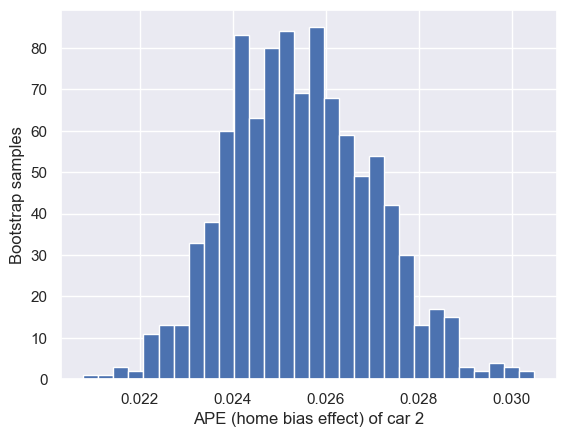

In [42]:
j = 1  # <-- change j to change cars
plt.hist(APE_own_boot[:, j], bins=30); 
plt.xlabel(f'APE (home bias effect) of car {j+1}'); 
plt.ylabel('Bootstrap samples'); 

**Bootstrapp mean:**

In [43]:
print(np.mean(APE_own_boot,axis=0))

[0.02889159 0.02547201 0.03141348 0.03691179 0.04075975 0.04150761
 0.041068   0.04223186 0.04275819 0.04031243 0.03916033 0.03906669
 0.03825292 0.03715701 0.03746904 0.03989919 0.03896746 0.03728271
 0.04147335 0.03975379 0.03749416 0.03895273 0.03739151 0.03856211
 0.03752042 0.03893121 0.04085511 0.04166468 0.04051846 0.03900006
 0.03966104 0.03956304 0.03804782 0.03992497 0.0395768  0.0412114
 0.04132054 0.04235054 0.03813481 0.03650589]


**Bootstrap standard deviation:**

In [44]:
print(np.std(APE_own_boot,axis=0))

[0.00152575 0.00154837 0.00186862 0.00178123 0.00202598 0.00182027
 0.00181409 0.00192448 0.00180689 0.0018132  0.00181082 0.00184884
 0.00186841 0.00177616 0.00172562 0.0018527  0.00165571 0.0016361
 0.00184892 0.00176389 0.00181265 0.00193807 0.00174621 0.00187379
 0.00175285 0.00177734 0.00175828 0.00174756 0.00181582 0.00189592
 0.00182604 0.00186282 0.00190633 0.00167138 0.001725   0.0018919
 0.0017743  0.00185485 0.00149584 0.00162079]
